## Alquiler de Vehiculo

Una empresa de alquiler de vehículos de alta gama a nivel mundial ha solicitado su ayuda para predecir si una nueva persona que se contacta por sus servicios (lead) se convertirá en una venta o no. Lo anterior resulta importante ya que un pronóstico anticipado de la calidad de estos leads permitirá una mejor asignación del esfuerzo comercial y de marketing.

Para el área de marketing esta información le permitirá por un lado evaluar si sus acciones pasadas han tenido resultados adecuados en lo que respecta a la atracción de clientes “rentables”. Así también le ayudará al desarrollo de mejores perfiles a futuro sobre los cuales invertir su presupuesto.

Para el área comercial, el pronóstico anticipado le permitirá una asignación más asertiva del tiempo y los recursos necesarios para concretar ventas. Por ejemplo, si la predicción de un nuevo lead indica que se convertirá en venta, la gerencia comercial podría asignar su seguimiento a un ejecutivo no tan experimentado; por el contrario, si la predicción indica que no será una venta, el ejecutivo a cargo podría tener un “seniority” mayor a fin de que a través de sus mejores conocimientos logre la conversión deseada.

Con este propósito, se le ha compartido un dataset llamado leads.xlsx el cual contiene datos históricos levantados por la empresa entre 2023 y 2024, y que incluye las siguientes columnas:

* id: Identificador único del lead que se contactó con la empresa
* producto: Nombre del producto de interés para el lead (A, B, C)
* sexo: Sexo del lead (F = Mujer, M = Hombre)
* dominio_email: Dominio del correo electrónico del lead
* grupo_geografico: Región geográfica en la que reside el lead (Estados Unidos, Europa, Latinoamérica, Oceanía, Otros)
* fuente: Forma de contacto del lead (Web, Remoto, Directo, Red Social)
* pautado: Si el lead se contactó debido a una campaña de marketing
* fecha_creacion: Fecha en la que se creó el lead dentro de los registros de la empresa
* fecha_conversion: Fecha en la que se convirtió el lead en una venta
* fecha_descalificacion: Fecha en que la empresa decidió terminar el contacto, y por ende se perdió la venta
* estado: Si el lead se convirtió en venta (=1), o si se perdió (=0)

In [39]:
# Importamos las librerias de procesamiento y aplicaciones matematicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importamos librerias de machine learning
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance # permite saber que variables son importantes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [3]:
# Traemos el DF
df = pd.read_excel('leads.xlsx', index_col='id')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4308 entries, 1 to 4308
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   producto               4308 non-null   object
 1   sexo                   4308 non-null   object
 2   dominio_email          4308 non-null   object
 3   grupo_geografico       4308 non-null   object
 4   fuente                 4308 non-null   object
 5   pautado                4308 non-null   int64 
 6   fecha_creacion         4308 non-null   object
 7   fecha_conversion       1385 non-null   object
 8   fecha_descalificacion  3007 non-null   object
 9   estado                 4308 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 370.2+ KB


In [5]:
# Variable objetivo
df['estado'].value_counts()

estado
0    2923
1    1385
Name: count, dtype: int64

In [6]:
df.sample(10)

,producto,sexo,dominio_email,grupo_geografico,fuente,pautado,fecha_creacion,fecha_conversion,fecha_descalificacion,estado
id,,,,,,,,,,
2950,A,F,yahoo,Europa,Web,0,2023-10-16,NaN,2023-10-17,0
1563,A,M,gmail,Estados Unidos,Red social,0,2023-04-11,NaN,2024-01-15,0
1685,B,F,gmail,Estados Unidos,Remoto,0,2023-04-20,NaN,2023-08-09,0
3708,B,F,gmail,Europa,Web,0,2024-05-08,NaN,2024-05-20,0
1966,B,F,gmail,Estados Unidos,Web,0,2023-07-17,2023-09-01,2023-08-09,1
3861,B,F,outlook,Estados Unidos,Remoto,0,2024-06-10,2024-06-12,NaN,1
555,A,F,gmail,Oceania,Web,1,2023-12-12,NaN,2024-03-24,0
1149,B,M,gmail,Estados Unidos,Web,0,2023-02-17,2023-02-23,NaN,1
1297,A,F,hotmail,Europa,Web,0,2023-03-17,NaN,2023-08-23,0


## Procesamiento de datos

In [7]:
# Convertimos nuestras columans de fecha en Datetime
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'])
df['fecha_conversion'] = pd.to_datetime(df['fecha_conversion'])
df['fecha_descalificacion'] = pd.to_datetime(df['fecha_descalificacion'])

In [8]:
df['antiguedad'] = df['fecha_descalificacion'] - df['fecha_creacion']
df.loc[np.isnat(df['antiguedad']), 'antiguedad'] = df['fecha_conversion'] - df['fecha_creacion']
df['antiguedad'] = df['antiguedad'].dt.days

In [9]:
df.sample(10)

,producto,sexo,dominio_email,grupo_geografico,fuente,pautado,fecha_creacion,fecha_conversion,fecha_descalificacion,estado,antiguedad
id,,,,,,,,,,,
1854,B,M,gmail,Latinoamerica,Web,0,2023-06-22,NaT,2024-01-23,0,215
1026,B,F,gmail,Estados Unidos,Web,0,2023-02-03,2023-02-07,NaT,1,4
406,B,F,gmail,Estados Unidos,Red social,1,2023-09-27,NaT,2024-01-22,0,117
483,A,M,gmail,Estados Unidos,Web,1,2023-10-23,NaT,2023-11-12,0,20
2529,A,F,gmail,Europa,Web,0,2023-11-04,NaT,2023-11-25,0,21
3886,B,M,gmail,Estados Unidos,Web,0,2024-06-24,NaT,2024-07-11,0,17
2269,B,M,outlook,Europa,Remoto,0,2023-09-14,2023-09-14,NaT,1,0
3493,A,F,gmail,Estados Unidos,Web,0,2024-03-19,NaT,2024-03-27,0,8
512,A,F,hotmail,Estados Unidos,Web,1,2023-11-14,NaT,2024-01-15,0,62


In [10]:
# Eliminamos las columans que no necesitamos
df = df.drop(columns= ['fecha_creacion', 'fecha_conversion', 'fecha_descalificacion'])

df.sample(10)

,producto,sexo,dominio_email,grupo_geografico,fuente,pautado,estado,antiguedad
id,,,,,,,,
582,A,M,gmail,Europa,Web,1,0,15
3477,A,F,gmail,Latinoamerica,Web,0,0,10
3075,B,F,icloud,Europa,Web,0,1,1
2720,A,M,gmail,Oceania,Web,0,0,110
1695,B,F,gmail,Estados Unidos,Web,0,1,1
1825,B,M,gmail,Estados Unidos,Web,0,1,3
1058,A,F,hotmail,Latinoamerica,Web,0,0,72
2902,A,M,yahoo,Estados Unidos,Web,0,1,14
3168,A,F,gmail,Europa,Directo,0,0,118


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4308 entries, 1 to 4308
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   producto          4308 non-null   object
 1   sexo              4308 non-null   object
 2   dominio_email     4308 non-null   object
 3   grupo_geografico  4308 non-null   object
 4   fuente            4308 non-null   object
 5   pautado           4308 non-null   int64 
 6   estado            4308 non-null   int64 
 7   antiguedad        4308 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 431.9+ KB


## Ingeneria de datos

In [12]:
# Codificamos nuestros textos
X = df.drop(columns='estado')
y = df['estado']

In [13]:
# Aplicamos One Hot Encoding se aplica a las variables categoricas
X_ohe = pd.get_dummies(X, dtype= int, drop_first= True)

In [14]:
X_ohe.describe().loc['mean']

pautado                            0.179666
antiguedad                        68.172238
producto_B                         0.449629
producto_C                         0.027159
sexo_M                             0.381616
dominio_email_btinternet           0.006500
dominio_email_comcast              0.018338
dominio_email_gmail                0.625580
dominio_email_hotmail              0.111421
dominio_email_icloud               0.020427
dominio_email_live                 0.006964
dominio_email_mac                  0.004875
dominio_email_me                   0.013928
dominio_email_msn                  0.010446
dominio_email_outlook              0.018106
dominio_email_verizon              0.004875
dominio_email_yahoo                0.118617
grupo_geografico_Europa            0.154828
grupo_geografico_Latinoamerica     0.086119
grupo_geografico_Oceania           0.022748
grupo_geografico_Otros             0.018570
fuente_Red social                  0.067317
fuente_Remoto                   

In [15]:
# Procedemos a escalar los datos
# Primero particinamos

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y , test_size=0.25, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3231, 24)
(3231,)
(1077, 24)
(1077,)


In [16]:
# Seleccionamos la variable a escalar
numerico = ['antiguedad']

# escalamos
escalador = StandardScaler()
escalador.fit(X_train[numerico])

,copy,True
,with_mean,True
,with_std,True


In [17]:

X_train[numerico] = escalador.transform(X_train[numerico])
X_test[numerico] = escalador.transform(X_test[numerico])

In [18]:
# Creacion del modelo
mod1 = LogisticRegression(random_state=123, solver='liblinear', max_iter=100)
mod1.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,123
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [19]:
y_pred = mod1.predict(X_test)


In [20]:
# Creamos nuestra matriz de confusion
mat_conf1 = pd.crosstab(y_test, y_pred)
mat_conf1.index=['Descalificado', 'Convertido']
mat_conf1.columns = ['Descalificado', 'Convertido']
mat_conf1

,Descalificado,Convertido
Descalificado,638,89
Convertido,119,231


In [21]:
# Extraemos nuestro reporte de metricas
print(metrics.classification_report(y_test, y_pred, target_names=['Descalificados', 'Convertidos'], digits=4))

                precision    recall  f1-score   support

Descalificados     0.8428    0.8776    0.8598       727
   Convertidos     0.7219    0.6600    0.6896       350

      accuracy                         0.8069      1077
     macro avg     0.7823    0.7688    0.7747      1077
  weighted avg     0.8035    0.8069    0.8045      1077



In [22]:
# Guardamos las metricas relevantes
acc1 = metrics.accuracy_score(y_test, y_pred)
f1_1 = metrics.f1_score(y_test, y_pred, average='weighted')

## Mejoramiento del modelo

In [23]:
# Creacion del modelo
mod2 = LogisticRegression(random_state=123, solver='liblinear', max_iter=100, class_weight='balanced')
mod2.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,123
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [24]:
y_pred2 = mod2.predict(X_test)

In [25]:
# Extraemos nuestro reporte de metricas
print(metrics.classification_report(y_test, y_pred2, target_names=['Descalificados', 'Convertidos'], digits=4))

                precision    recall  f1-score   support

Descalificados     0.9405    0.7607    0.8411       727
   Convertidos     0.6442    0.9000    0.7509       350

      accuracy                         0.8059      1077
     macro avg     0.7923    0.8303    0.7960      1077
  weighted avg     0.8442    0.8059    0.8118      1077



In [26]:
# Guardamos las metricas relevantes
acc2 = metrics.accuracy_score(y_test, y_pred2)
f1_2 = metrics.f1_score(y_test, y_pred2, average='weighted')

In [27]:
# Mejoramiento del umbral con curva ROC
y_pred_p = mod2.predict_proba(X_test)
y_pred_p = y_pred_p[:,1]
y_pred_p

array([2.08056845e-04, 6.47074956e-01, 2.69148031e-01, ...,
       2.72066782e-01, 2.53477078e-01, 9.40990294e-01], shape=(1077,))

In [28]:
# Creamos la curva ROC
fpr, tpr, umbral = metrics.roc_curve(y_test, y_pred_p)

df_roc = pd.DataFrame(dict(
    fpr = fpr,
    tpr = tpr,
    umbral = umbral
))

df_roc

,fpr,tpr,umbral
0,0.000000,0.000000,inf
1,0.000000,0.002857,0.966274
2,0.000000,0.008571,0.957259
3,0.000000,0.022857,0.944611
4,0.000000,0.028571,0.941366
...,...,...,...
307,0.983494,0.994286,0.000305
308,0.994498,0.994286,0.000207
309,0.994498,0.997143,0.000126
310,1.000000,0.997143,0.000022


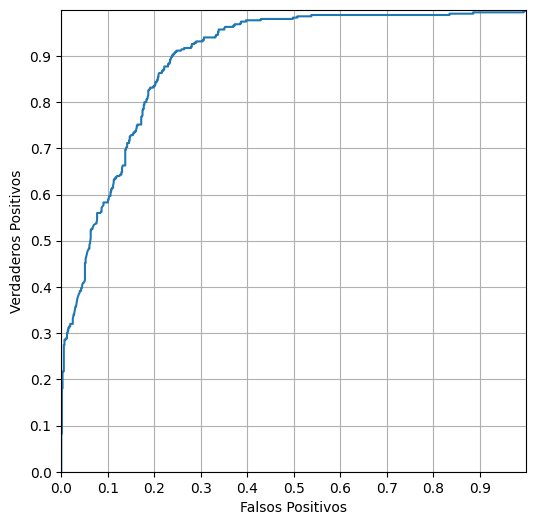

In [29]:
df_roc.plot(
    x = 'fpr',
    y = 'tpr',
    kind='line',
    legend=False,
    xlim=[0,1],
    ylim=[0,1],
    xticks=np.array(range(0,100,10))/100,
    yticks=np.array(range(0,100,10))/100,
    xlabel='Falsos Positivos',
    ylabel='Verdaderos Positivos',
    figsize=[6,6],
    grid=True
)
plt.show()

In [30]:
# Seleccinamos el mejor umbral
f1_max = f1_2
u_max = 0.5

for u in umbral:
    y_pred_nuevo = []

    for y in y_pred_p:
        if y > u:
            y_pred_nuevo.append(1)
        else:
            y_pred_nuevo.append(0)
    f1_iter = metrics.f1_score(y_test, y_pred_nuevo, average='weighted')

    if f1_iter > f1_max:
        f1_max = f1_iter
        u_max = u

print(f'Score F1 máximo:{f1_max:.4f}')
print(f'Umbral:{u_max:.4f}')

Score F1 máximo:0.8210
Umbral:0.5975


In [31]:
# Corriendo el modelo con el umbral optimo
y_pred_nuevo = []

for y in y_pred_p:
    if y > u_max:
        y_pred_nuevo.append(1)
    else:
        y_pred_nuevo.append(0)

In [32]:
# Creamos nuestra matriz de confusion
mat_conf3 = pd.crosstab(y_test, y_pred_nuevo)
mat_conf3.index=['Descalificado', 'Convertido']
mat_conf3.columns = ['Descalificado', 'Convertido']
mat_conf3

,Descalificado,Convertido
Descalificado,591,136
Convertido,61,289


In [33]:
# Extraemos nuestro reporte de metricas
print(metrics.classification_report(y_test, y_pred_nuevo, target_names=['Descalificados', 'Convertidos'], digits=4))

                precision    recall  f1-score   support

Descalificados     0.9064    0.8129    0.8571       727
   Convertidos     0.6800    0.8257    0.7458       350

      accuracy                         0.8171      1077
     macro avg     0.7932    0.8193    0.8015      1077
  weighted avg     0.8329    0.8171    0.8210      1077



In [34]:
# Guardamos las metricas relevantes
acc3 = metrics.accuracy_score(y_test, y_pred_nuevo)
f1_3 = metrics.f1_score(y_test, y_pred_nuevo, average='weighted')

In [35]:
resumen = pd.DataFrame(dict(
    Exactitud = [acc1, acc2, acc3],
    f1_score = [f1_1,f1_2,f1_3]
))
resumen

,Exactitud,f1_score
0,0.806871,0.804499
1,0.805942,0.811761
2,0.817084,0.820961


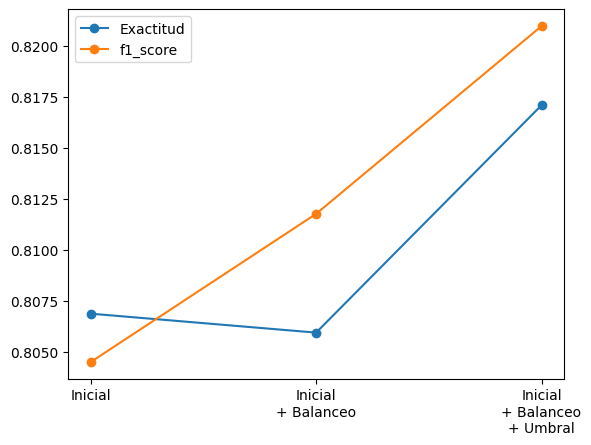

In [36]:
resumen.plot(
    kind='line',
    marker = 'o',
    style='-'
)
plt.xticks(ticks=[0,1,2], labels=['Inicial', 'Inicial\n+ Balanceo', 'Inicial\n+ Balanceo\n+ Umbral'])
plt.show()

In [37]:
auc3 = metrics.roc_auc_score(y_test, y_pred_nuevo)
auc2 = metrics.roc_auc_score(y_test, y_pred2)
auc1 = metrics.roc_auc_score(y_test, y_pred)
print(auc3*100)
print(auc2*100)
print(auc1*100)

81.93220672037728
83.03301237964237
76.878954607978
